In [1]:
import pandas as pd
from datasets import Dataset
from transformers import GPT2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import time

# GPU check
if torch.cuda.is_available():
    print("GPU using:", torch.cuda.get_device_name(0))
else:
    print("GPU not available.")


GPU using: NVIDIA GeForce RTX 4080


In [2]:
df = pd.read_csv('./dataset/mail_phishing.csv')  

dataset = Dataset.from_pandas(df)

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token  

model = AutoModelForSequenceClassification.from_pretrained("distilgpt2", num_labels=2)
model.config.pad_token_id = model.config.eos_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

c:\Users\Vincent\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vincent\.cache\huggingface\hub\models--distilgpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def tokenize(batch):
    return tokenizer(batch["text_combined"], padding="max_length", truncation=True)

start_time = time.time()
dataset = dataset.map(tokenize, batched=True)
end_time = time.time()

tokenize_duration = end_time - start_time

split = dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
test_dataset = split["test"]

Map:   0%|          | 0/82486 [00:00<?, ? examples/s]

In [5]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


In [6]:
training_args = TrainingArguments(
    output_dir="./gpt2-mail-phishing",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

start_time = time.time()
trainer.train()
end_time = time.time()

training_duration = end_time - start_time

Step,Training Loss
500,0.202800
1000,0.105200
1500,0.085600
2000,0.063500
2500,0.059500
3000,0.049000
3500,0.060300
4000,0.036200
4500,0.027400
5000,0.017600


In [7]:
#metriken
metrics = trainer.evaluate()
print("\nmetrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"tokenize_runtime: {tokenize_duration:.2f} Sekunden ({tokenize_duration/60:.2f} Minuten)")
print(f"train_runtime: {training_duration:.2f} Sekunden ({training_duration/60:.2f} Minuten)")


metrics:
eval_loss: 0.0284
eval_accuracy: 0.9953
eval_f1: 0.9955
eval_precision: 0.9975
eval_recall: 0.9935
eval_runtime: 99.9363
eval_samples_per_second: 165.0850
eval_steps_per_second: 20.6430
epoch: 3.0000
tokenize_runtime: 121.17 Sekunden (2.02 Minuten)
train_runtime: 3601.23 Sekunden (60.02 Minuten)


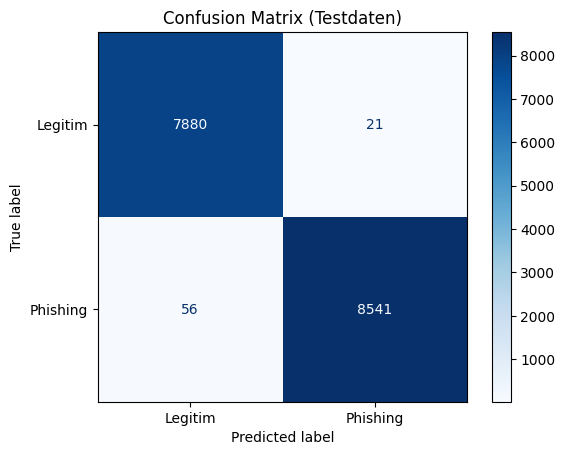

In [8]:
# confusion matrix
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitim", "Phishing"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Testdaten)")
plt.show()

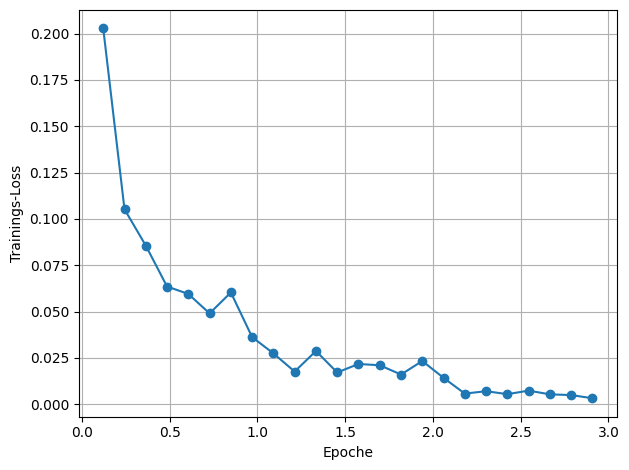

In [9]:
# Loss curve plot
logs = trainer.state.log_history
epoch_logs = [log for log in logs if "loss" in log and "epoch" in log]
df = pd.DataFrame(epoch_logs)

plt.plot(df["epoch"], df["loss"], marker='o')
plt.xlabel("Epoche")
plt.ylabel("Trainings-Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
